# Study

## Series Analysis

### Example: Fibonacci

a(0) = 1

a(1) = 1

a(n) = a(n-2) + a(n-1)

a(n) = Xa(n-2) + Ya(n-1)

## Data load and training / test sets initialization

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from IPython.display import display, HTML
%matplotlib inline

def stoarray(data = [], sep = ','):
    return data.map(lambda x: np.array(x.split(sep), dtype=np.longdouble))

# load the data
colna = ['id', 'seq']
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test.columns = colna
train.columns = colna
train['seq'], test['seq'] = stoarray(train['seq']), stoarray(test['seq'])
train.head()
#display(pd.DataFrame(train.seq[1].astype(int)))

,id,seq
0,3,"[1.0, 3.0, 13.0, 87.0, 1053.0, 28576.0, 214173..."
1,7,"[1.0, 2.0, 1.0, 5.0, 5.0, 1.0, 11.0, 16.0, 7.0..."
2,8,"[1.0, 2.0, 4.0, 5.0, 8.0, 10.0, 16.0, 20.0, 32..."
3,11,"[1.0, 8.0, 25.0, 83.0, 274.0, 2275.0, 132224.0..."
4,13,"[1.0, 111.0, 12211.0, 1343211.0, 147753211.0, ..."


## Feature extraction of a determined sequence

In [2]:
# returns a test set matrix [Xi, X1, X2, X3... Xn-2, Xn-1, Xn, y]
def getTrainingSet(seq):
    xlen = seq.shape[0]
    x = np.array([])
    trainingSet = np.zeros([xlen, xlen+1])
    columns = []
    for i in range(xlen):
        xi = np.array([float(i)])
        x1 = np.concatenate((seq[:i], np.zeros(xlen-1-i)))
        y1 = seq[i:i+1]
        trainingSet[i] = np.concatenate((xi, x1, y1))
        columns.append("x" + str(i))
    columns.append("y")
    # mirror lr
    # trainingSet[:,1:-1] = np.fliplr(trainingSet[:,1:-1])
    return trainingSet, columns

trainingSet, columns = getTrainingSet(train.seq[4][:-1])
#X = pd.DataFrame(trainingSet[:,:-1].astype(int), columns=columns[:-1])
#y = pd.DataFrame(trainingSet[:,-1:].astype(int), columns=columns[-1:])
#display(X, y)

### TEST
#np.set_printoptions(precision=99)
#print(train.seq[4][-1:].astype(np.longdouble), predictLast(train.seq[4][:-1]).astype(np.longdouble))
#display(pd.DataFrame(trainingSet.astype(np.longdouble), columns=columns))

## Fit a Linear Regression model

In [35]:
display(pd.DataFrame([
            ["x0", "x1", "x2", "x3", "y"],
            ["x00", "x01", "x02", "x03", "y0"],
            ["x10", "x02", "x03", "x13", "y1"],
            ["x20", "x12", "x13", "x23", "y1"],
        ]))
print("to transform m into shifted ngrams matrix that's idea...")

# performs dimensionality reduction using ngrams
def getTrainingSetNgram(seq):
    m, columns = getTrainingSet(seq)
    n = int((m.shape[1]-2)/2+1) # n-gram n value
    # n == 15 best cut off - by try and error discovery
    if n > 15:
        n = 15
    #print("n-gram:", n, len(seq))
    mp = np.array([m[:,0], *tuple(np.zeros([n, m.shape[1]-1])), m[:,-1]]).transpose()
    # complete diagonals - ngram matrix
    for i in range(n):
        for j in range(1,n):
            if n-i+j <= n:
                mp[i,n-i+j] = m[i,j]
    # complete matrix ngrams body
    for i in range(n, m.shape[0]):
        mp[i,1:1+n] = m[i,1-n+i:1+i]
    columns[mp.shape[1]-1] = "y"
    # vertical mirror center of matrix
    #    mp[:,1:-1] = np.fliplr(mp[:,1:-1])
    #    mp = np.flipud(mp)
    # drop zero line
    mp = mp[n:,]
    #return mp, columns[:mp.shape[1]]
    
    return mp, columns[:mp.shape[1]]

trainingSet, columns = getTrainingSet(train.seq[1][:-1])
#display(pd.DataFrame(trainingSet.astype(int), columns=columns))

trainingSet, columns = getTrainingSetNgram(train.seq[1][:-1])
display(pd.DataFrame(trainingSet.astype(int), columns=columns))

,0,1,2,3,4
0,x0,x1,x2,x3,y
1,x00,x01,x02,x03,y0
2,x10,x02,x03,x13,y1
3,x20,x12,x13,x23,y1


to transform m into shifted ngrams matrix that's idea...


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
0,15,1,2,1,5,5,1,11,16,7,1,23,44,30,9,1,47
1,16,2,1,5,5,1,11,16,7,1,23,44,30,9,1,47,112
2,17,1,5,5,1,11,16,7,1,23,44,30,9,1,47,112,104
3,18,5,5,1,11,16,7,1,23,44,30,9,1,47,112,104,48
4,19,5,1,11,16,7,1,23,44,30,9,1,47,112,104,48,11
5,20,1,11,16,7,1,23,44,30,9,1,47,112,104,48,11,1
6,21,11,16,7,1,23,44,30,9,1,47,112,104,48,11,1,95
7,22,16,7,1,23,44,30,9,1,47,112,104,48,11,1,95,272
8,23,7,1,23,44,30,9,1,47,112,104,48,11,1,95,272,320
9,24,1,23,44,30,9,1,47,112,104,48,11,1,95,272,320,200


### Generate computed features

In [36]:
def generateExtraFeatures(mX):
    n = mX.shape[1]
    #for i in range(1, n-1):
    #    mX = mX
    #    mX = np.concatenate((mX, mX[:,i:i+1]**2), axis=1) # Xn^2
    #    mX = np.concatenate((mX, np.cos(mX[:,i:i+1])), axis=1) # cos
    #    mX = np.concatenate((mX, np.cos(mX[:,i:i+1])), axis=1) # sin
    #    mX = np.concatenate((mX, np.exp(mX[:,i:i+1])), axis=1) # exp
    #    mX = np.concatenate((mX, np.log(mX[:,i:i+1])), axis=1) # exp
    if (n > 11):
        return mX
    for i in range(1, n-2):
        mX = np.concatenate((mX, mX[:,i+1:i+2] - mX[:,i+0:i+1]), axis=1) # X(n+1) - X(n)
        mX = np.concatenate((mX, np.angle(mX[:,i+1:i+2] - mX[:,i+0:i+1])), axis=1) # X(n+1) v X(n)
    return mX

trainingSet, columns = getTrainingSetNgram(train.seq[2][:-1])
generateExtraFeatures(trainingSet)

array([[  1.50000000e+01,   1.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   5.00000000e+00,   8.00000000e+00,
          1.00000000e+01,   1.60000000e+01,   2.00000000e+01,
          3.20000000e+01,   4.00000000e+01,   6.40000000e+01,
          8.00000000e+01,   1.28000000e+02,   1.60000000e+02,
          2.56000000e+02,   3.20000000e+02],
       [  1.60000000e+01,   2.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   8.00000000e+00,   1.00000000e+01,
          1.60000000e+01,   2.00000000e+01,   3.20000000e+01,
          4.00000000e+01,   6.40000000e+01,   8.00000000e+01,
          1.28000000e+02,   1.60000000e+02,   2.56000000e+02,
          3.20000000e+02,   5.12000000e+02],
       [  1.70000000e+01,   4.00000000e+00,   5.00000000e+00,
          8.00000000e+00,   1.00000000e+01,   1.60000000e+01,
          2.00000000e+01,   3.20000000e+01,   4.00000000e+01,
          6.40000000e+01,   8.00000000e+01,   1.28000000e+02,
          1.60000000e+02,   2.56000000e+02

## Predict Model function

In [24]:
def predictLast(seq):
    if seq.shape[0] == 0:
        return 0
    if seq.shape[0] == 1:
        return seq[0]
    if seq.shape[0] == 2:
        return seq[1]
    
    trainingSet, columns = getTrainingSetNgram(seq)
    X = trainingSet[:,:-1]
    X = generateExtraFeatures(X)
    X = pd.DataFrame(X)
    y = pd.DataFrame(trainingSet[:,-1:], columns=columns[-1:])
    
    #display(pd.DataFrame(trainingSet.astype(int), columns=columns))
    #display(pd.DataFrame(X.astype(int)))

    testIndex = np.array([int(seq.shape[0])])
    testRow = trainingSet[-1:,2:][0];
    testRowX = np.array([np.concatenate((testIndex, testRow))])
    
    # add extra
    testRowX = generateExtraFeatures(testRowX)
    testRowX = pd.DataFrame(testRowX)
    
    # train
    regresor = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=3)
    regresor.fit(X.as_matrix(), y.as_matrix())
    
    outFinal = regresor.predict(testRowX.as_matrix())
    return outFinal[-1:][0][0]

### Function to draw curves

In [37]:
def plotSubset(set, subsetName):
    l = len(set)-1
    plt.figure(figsize=(15, int(5*(l/5))))
    plt.suptitle(subsetName + "subset", fontsize="x-large")
    for k in range(l):
        y = set[1+k]
        x = np.linspace(1, len(y),len(y))
        plt.subplot(int(5*(l/10)), 5, 1+k)
        
        # plot the points
        plt.scatter(x, y, s=10, c='green', alpha=0.7)
        
        # Dots [...., last (red), plastp (orange), lastp (blue)]
        plt.scatter(x[-3:-2], y[-3:-2], s=70, c='red', alpha=0.4) # last trained
        plt.scatter(x[-2:-1], y[-2:-1], s=70, c='orange', alpha=0.30) # prev last predicted
        plt.scatter(x[-1], y[-1], s=80, c='blue', alpha=0.4) # last predicted
        
        # Line from last trained to last predicted
        plt.plot([x[-3:-2],x[-1]], [y[-3:-2],y[-1]], c='orange', alpha=1) # diff between trained and predicted
        
        plt.plot(x, y, c='gray', alpha=0.3)
        plt.axis('off')
    #plt.savefig('e01.png')
    
#plotSubset(train, "Train subset")
#plotSubset(test, "Test subset")

### Test predictive model with Training set

414 / 2000 matches; zeros = 8, accuracy = 0.207000 
849 / 4000 matches; zeros = 8, accuracy = 0.212250 
1264 / 6000 matches; zeros = 8, accuracy = 0.210667 
1691 / 8000 matches; zeros = 8, accuracy = 0.211375 
2120 / 10000 matches; zeros = 10, accuracy = 0.212000 
2551 / 12000 matches; zeros = 11, accuracy = 0.212583 
2991 / 14000 matches; zeros = 12, accuracy = 0.213643 
3407 total matches


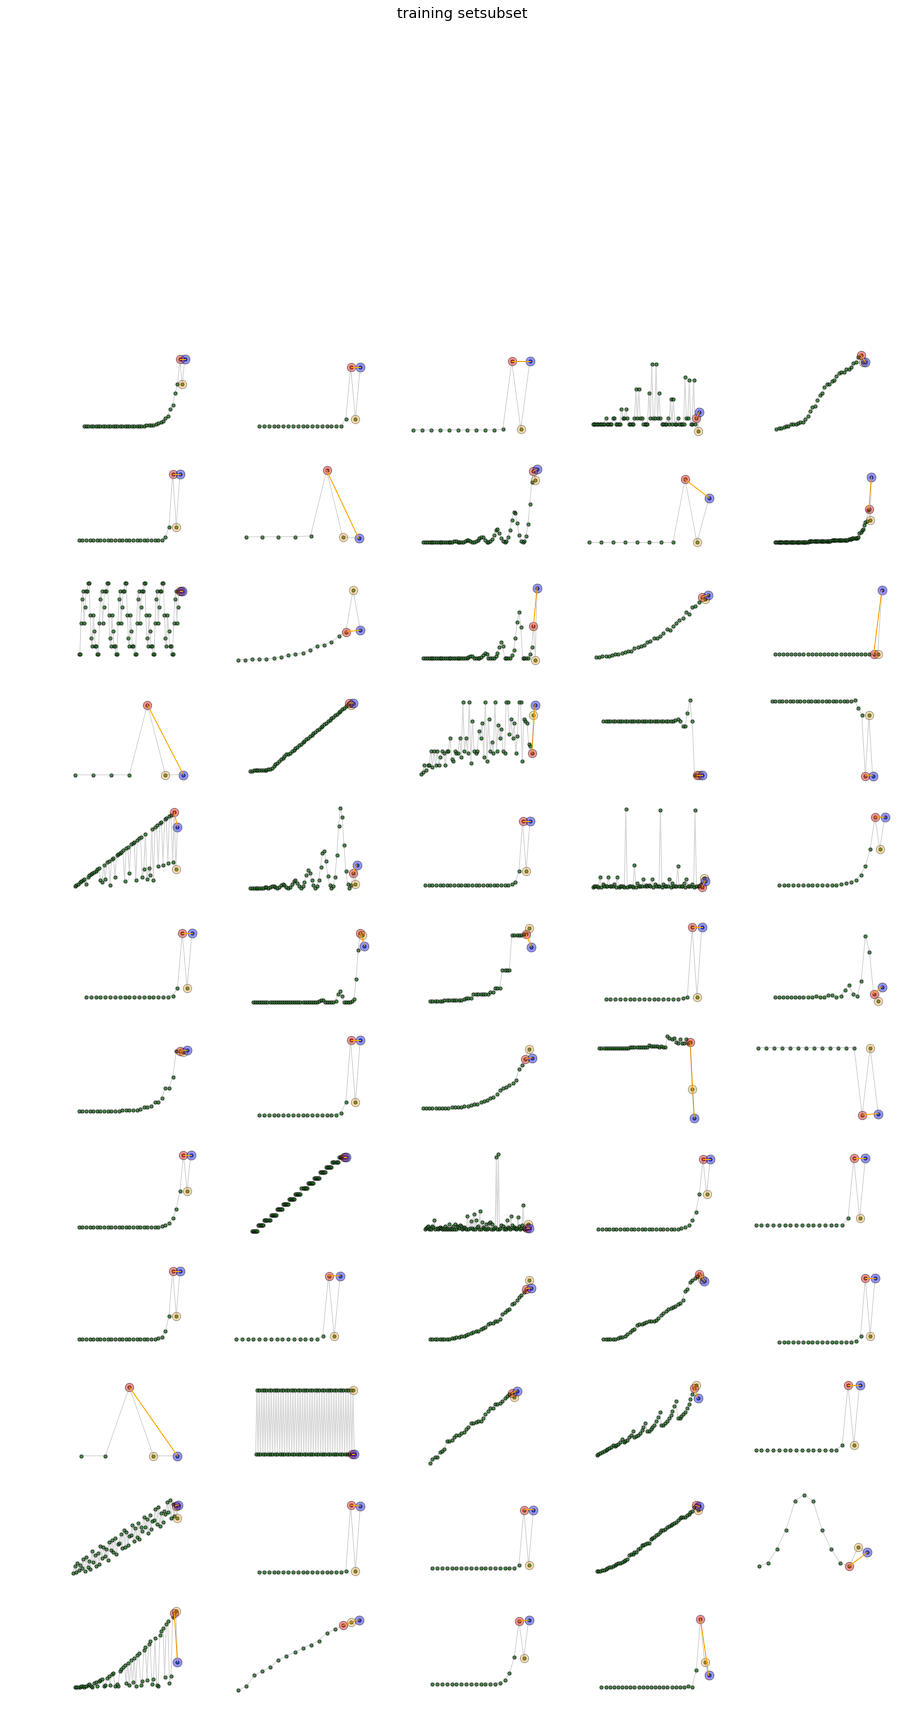

In [48]:
pmatches = 0
matches = 0
zeros = 0
output = []
sets = []
#for i in range(len(train)):
for i in range(1,16000):
    seq = train.seq[i].astype(np.longdouble)
    
    plast = seq[-2:-1]
    plastpredicted = predictLast(seq[:-2])
    
    last = seq[-1:]
    lastpredicted = predictLast(seq[:-1])
    
    output.append([train.id[i], int(lastpredicted)])
    sets.append(np.concatenate((train.seq[i], [plastpredicted], [lastpredicted])))
    
    diff = int(last - lastpredicted)
    if diff == 0:
        matches += 1
    if lastpredicted == 0:
        zeros += 1
    if i>0 and i%2000==0:
        print("%d / %d matches; zeros = %d, accuracy = %f " % (matches, i, zeros, float(matches)/float(i)))
              
print("%d total matches" % matches)

plotSubset(sets[:60], 'training set')

pd.DataFrame(output).to_csv("train_submission.csv", header=["Id", "Last"], index=False, index_label=False)

### Test predictive model with Test set

In [18]:
output = []

for i in range(len(test)):
    seq = test.seq[i];#.astype(np.longdouble)
    lastpredicted = predictLast(seq)
    
    plast = seq[-1:]
    #@TODO try if np.abs(plast - plastpredicted) > np.abs(lastpredicted - plast):
    if np.abs(plast - lastpredicted) > 10:
        lastpredicted = plast
    
    
    try:
        output.append([test.id[i], int(lastpredicted)])
    except OverflowError:
        output.append([test.id[i], int(seq[-1:])])
        
    if i>0 and i%2000==0:
        print("%d / %d done" % (i, len(test)))
              
pd.DataFrame(output).to_csv("submission13.csv", header=["Id", "Last"], index=False, index_label=False)

2000 / 113845 done
4000 / 113845 done
6000 / 113845 done
8000 / 113845 done
10000 / 113845 done
12000 / 113845 done
14000 / 113845 done
16000 / 113845 done
18000 / 113845 done
20000 / 113845 done
22000 / 113845 done
24000 / 113845 done
26000 / 113845 done
28000 / 113845 done
30000 / 113845 done
32000 / 113845 done
34000 / 113845 done
36000 / 113845 done
38000 / 113845 done
40000 / 113845 done
42000 / 113845 done
44000 / 113845 done
46000 / 113845 done
48000 / 113845 done
50000 / 113845 done
52000 / 113845 done
54000 / 113845 done
56000 / 113845 done
58000 / 113845 done
60000 / 113845 done
62000 / 113845 done
64000 / 113845 done
66000 / 113845 done
68000 / 113845 done
70000 / 113845 done
72000 / 113845 done
74000 / 113845 done
76000 / 113845 done
78000 / 113845 done
80000 / 113845 done
82000 / 113845 done
84000 / 113845 done
86000 / 113845 done
88000 / 113845 done
90000 / 113845 done
92000 / 113845 done
94000 / 113845 done
96000 / 113845 done
98000 / 113845 done
100000 / 113845 done
102